 ## The Super Learner

## Import Packages

In [251]:
#imports and packages
from IPython.display import display, HTML, Image
from sklearn.base import BaseEstimator, ClassifierMixin
import pandas as pd
import numpy as np
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import sklearn.cross_validation as cv
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn import neural_network
from sklearn.model_selection import KFold
from sklearn import datasets, svm, linear_model, neighbors, svm
import itertools
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
plt.style.use('classic')
SEED = 222
np.random.seed(SEED)
from sklearn.ensemble import AdaBoostClassifier

In [198]:
import seaborn as sns
sns.set()

<h2>SUPER LEARNER</h2>
<br>
The *Super Learner* is a heterogeneous stacked ensemble classifier. This is a classification model that uses a set of base classifiers of different types, the outputs of which are then combined in another classifier at the stacked layer. The Super Learner was described in [(van der Laan et al, 2007)](https://pdfs.semanticscholar.org/19e9/c732082706f39d2ba12845851309714db135.pdf) but the stacked ensemble idea has been around for a long time. 


### Define the SuperLearnerClassifier Class

In [252]:
#Super Learner Class
class SuperLearnerClassifier(BaseEstimator,ClassifierMixin):
    
    def __init__(self, baseModels= None, stackModel=None,predProba=False,useOriginalInput=False,cv_folds=5,K=5,global_stack=None):
        self.cv_folds=cv_folds
        self.baseModels=baseModels
        self.K=K
        self.stackModel=stackModel
        self.predProba=predProba
        self.useOriginalInput=useOriginalInput
        self.global_stack=global_stack
    #The fit method for the SuperLEarner    
    def fit(self,X,y):
        #Set of base learners 
        baseLearnerSet=set(self.baseModels)
        
        stacked_predictions_fit=[]
        #KFold for splitting the data
        kf = KFold(n_splits=5)
        for train,test in kf.split(X):
            X_train=np.array(X)[train]
            Y_train=np.array(y)[train]
            X_test = np.array(X)[test]
            Y_Test = np.array(y)[test]
            #Fitting the model using the train data
            for i,model in enumerate(self.baseModels):
                model.fit(X_train,Y_train)
            predicted_values=[]
            #making base models predict labels or probabilities based on the predProba flag
            for i,model in enumerate(self.baseModels):
                if self.predProba==False:
                    P=model.predict(X_test)
                else:
                    P=model.predict_proba(X_test)
                predicted_values.append(P.tolist())
            stacked_predictions_fit.extend(np.column_stack(predicted_values).tolist())
        #Stacking the X with the stacked predictions (Question 8)
        if self.useOriginalInput==True:
            stacked_predictions_fit = np.column_stack((X,stacked_predictions_fit))

        #Training the meta learner
        meta_tree= self.stackModel
        self.global_stack=stacked_predictions_fit
        meta_tree.fit(stacked_predictions_fit,y)
        self.stackModel=meta_tree
        #Fitting the base models using the whole dataset again
        print("Done")
        for i,model in enumerate(self.baseModels):
            model.fit(X,y)
            
        return self
    #predict method for the superLearner
    def predict(self,X):
        stacked_predictions_fit=[]
        predicted_values=[]
        for i,model in enumerate(self.baseModels):
            if self.predProba==False:
                P=model.predict(X)
            else:
                P=model.predict_proba(X)
            predicted_values.append(P.tolist())
        stacked_predictions_fit.extend(np.column_stack(predicted_values).tolist())
        if self.useOriginalInput==True:
            stacked_predictions_fit = np.column_stack((X,stacked_predictions_fit))
        #making the stackModel predict on the stacked predictions from the base learners (class label)
        final_Predictions=self.stackModel.predict(stacked_predictions_fit)
        return final_Predictions
    #predict proba method for the superLearner
    def predict_proba(self,X):
        stacked_predictions_fit=[]
        predicted_values=[]
        for i,model in enumerate(self.baseModels):
            if self.predProba==False:
                P=model.predict(X)
            else:
                P=model.predict_proba(X)
            predicted_values.append(P.tolist())
        stacked_predictions_fit.extend(np.column_stack(predicted_values).tolist())
        if self.useOriginalInput==True:
            stacked_predictions_fit = np.column_stack((X,stacked_predictions_fit))
        #making the trained stackModel predict on the stacked predictions of base learners (probability outputs)
        final_Predictions=self.stackModel.predict_proba(stacked_predictions_fit)
        return final_Predictions

        cArray=np.array(corrMatrix)
        mask = np.zeros_like(cArray)
        mask[np.triu_indices_from(mask)] = True
        with sns.axes_style("white"):
            ax = sns.heatmap(cArray, mask=mask, vmax=.3, square=True)
        
    #The function which shows the Accuracy,F1Score,Recall,Precision 
    def predictivePowerEnsemble(self,Xtest,YTest):
        for i,model in enumerate(self.baseModels):
            print("Predictive Power of Each of the base model- Model"+str(i+1))
            pr=model.predict(Xtest)
            a = metrics.accuracy_score(pr,YTest)
            f1=metrics.f1_score(pr,YTest,average='weighted')
            r=metrics.recall_score(pr,YTest,average='weighted')
            p=metrics.precision_score(pr,YTest,average='weighted')
            print("Accuracy"+str(a))
            print("F1-Measure"+str(f1))
            print("Recall"+str(r))
            print("Precision"+str(p))
                 
        return 
    #The function to print the confusion heatmap of the confusion matrices of the base learners
    def confusionHeatMap(self,Xtest,YTest):
        confusion_aggregate=[]
        labels=["Gaussian","SVC","KNN","Linear Regression","MLP","GradientBoost","RandomForest"]
        for i,model in enumerate(self.baseModels):
            pr=model.predict(XTest)
            matrix=metrics.confusion_matrix(YTest,pr)
            confusion_aggregate.append(matrix)
            
        conf={
        1:{
            'matrix':confusion_aggregate[0],
            'title':labels[0]
        }, 
         2:{
            'matrix':confusion_aggregate[1],
            'title':labels[1]
        }, 
         3:{
            'matrix':confusion_aggregate[2],
            'title':labels[2]
        }, 
         4:{
            'matrix':confusion_aggregate[3],
            'title':labels[3]
        }, 
         5:{
            'matrix':confusion_aggregate[4],
            'title':labels[4]
        }, 
         6:{
            'matrix':confusion_aggregate[5],
            'title':labels[5]
        }, 
         7:{
            'matrix':confusion_aggregate[6],
            'title':labels[6]
        }
    }
        fix, ax = plt.subplots(figsize=(16, 12))
        plt.suptitle('Confusion Matrix of Various Classifiers')
        for ii, values in conf.items():
            print("inside")
            matrix = values['matrix']
            title = values['title']
            plt.subplot(3, 4, ii) # starts from 1
            plt.title(title);
            sns.heatmap(matrix, annot=True,  fmt='');
        plt.show()
            
            
        return 
    #function to print the scatter plot of the predictions
    def scatterPlotforPrediction(self):
        print("Scatter Plot showing the predictions plot")
        d =pd.DataFrame(self.global_stack)
        scatter_matrix(d)
        


### Test the SuperLearnerClassifier

Perform a simple test using the SuperLearnClassifier on the Iris dataset

In [153]:
from sklearn.datasets import load_iris
nb = GaussianNB()
svc = SVC(C=100, probability=True)
knn = KNeighborsClassifier(n_neighbors=3)
lr = LogisticRegression(C=100, random_state=SEED)
nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)
baseModels=[nb,svc,knn,lr,nn,gb,rf]
stackModel=tree.DecisionTreeClassifier(criterion="entropy")
clf = SuperLearnerClassifier(baseModels,stackModel,predProba=False,useOriginalInput=False)
iris = load_iris()
clf.fit(iris.data, iris.target)
iris_Score=cross_val_score(clf, iris.data, iris.target, cv=10)

/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), Converge

Done


/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), Converge

Done


/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), Converge

Done


/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), Converge

Done


/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), Converge

Done


/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), Converge

Done


/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), Converge

Done


/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), Converge

Done


/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), Converge

Done


/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), Converge

Done


/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), Converge

Done


/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [154]:
iris_Score

array([ 1.        ,  0.93333333,  1.        ,  0.93333333,  0.86666667,
        0.93333333,  0.86666667,  1.        ,  1.        ,  1.        ])

In [155]:
iris_Score.mean()

0.95333333333333337

## Load & Partition Data

### Setup - IMPORTANT

Taking only a sample of the dataset for fast testing

In [200]:
data_sampling_rate = 0.1

Setup the number of folds for all grid searches (should be 5 - 10)

In [201]:
cv_folds = 2

### Load Dataset

Loading the dataset and expoloration.

In [202]:
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
49997,4,0,0,0,0,0,0,0,0,0,...,189,91,0,120,126,40,0,0,0,0
43288,2,0,0,0,0,0,0,0,0,0,...,0,0,0,8,96,60,0,0,0,0
57239,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
364,4,0,0,0,0,0,0,0,0,2,...,0,0,1,0,66,138,124,16,0,0
57711,3,0,0,0,0,0,0,0,0,4,...,56,26,14,0,0,0,0,0,0,0


### Pre-process & Partition Data

Perform data pre-processing and manipulation as required

In [203]:
#Partitioning the Data
# Add code here
X = dataset[dataset.columns[1:]]
Y = np.array(dataset["label"])
#Splitting the Data to train,test and validation from X,Y
XTrainVal,XTest,YTrainVal,YTest = train_test_split(X, Y, random_state=0, \
                                    train_size = 0.7)
#Splitting XTrainVal to XTrain and XVal
XTrain,XVal,YTrain,YVal = train_test_split(XTrainVal, YTrainVal, random_state=0, \
                                    train_size = 0.5/0.7)

In [213]:
#Loading DataSet from the MNIST test csv
data_sampling_rate_test = 0.05
cv_folds_test = 2
d_test = pd.read_csv('fashion-mnist_test.csv')
d_test = dataset.sample(frac=data_sampling_rate_test) #take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(d_test.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
587,0,0,0,0,0,0,1,8,22,4,...,68,47,22,1,0,0,0,0,0,0
53784,0,0,0,0,1,0,0,19,51,117,...,39,28,14,26,13,0,1,0,0,0
29380,2,0,0,0,0,0,1,0,0,0,...,0,0,0,82,109,50,0,0,0,0
47588,0,0,0,0,0,0,0,0,0,0,...,87,4,0,1,0,0,0,0,0,0
30575,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [215]:
#Partitioning the Test Data
X_test = d_test[dataset.columns[1:]]
Y_test = np.array(d_test["label"])
#Splitting the Data to train,test and validation from X,Y
XTrain_test,XTest_test,YTrain_test,YTest_test = train_test_split(X_test, Y_test, random_state=0, \
                                    train_size = 0.5)


## Train and Evaluate a Simple Model

Train a Super Learner Classifier using the prepared dataset

In [205]:
nb = GaussianNB()
svc = SVC(C=100, probability=True)
knn = KNeighborsClassifier(n_neighbors=3)
lr = LogisticRegression(C=100, random_state=SEED)
nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)
baseModels=[nb,svc,knn,lr,nn,gb,rf]
stackModel=tree.DecisionTreeClassifier(criterion="entropy")
superLearner = SuperLearnerClassifier(baseModels,stackModel)
superLearner.fit(XTrain,YTrain)

Done


SuperLearnerClassifier(K=5,
            baseModels=[GaussianNB(priors=None), SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False), KNeighborsClassifier(algorithm='auto', ...stimators=10, n_jobs=1, oob_score=False, random_state=222,
            verbose=0, warm_start=False)],
            cv_folds=5,
            global_stack=[[9, 0, 9, 9, 0, 9, 9], [7, 0, 7, 7, 0, 9, 7], [2, 0, 2, 2, 0, 2, 2], [5, 0, 9, 5, 0, 5, 5], [3, 0, 3, 3, 0, 3, 3], [4, 0, 2, 2, 0, 2, 2], [1, 0, 1, 1, 0, 1, 1], [8, 0, 8, 8, 0, 8, 2], [7, 0, 5, 5, 7, 5, 5], [7, 0, 7, 7, 7, 7, 7], [7, 0, 5, 5, 7, 5, 5], [1, 0, 1, 1, 0, 1, 1], [7, 0, 9, ..., 9, 7], [3, 0, 6, 6, 0, 6, 6], [1, 0, 1, 1, 0, 1, 1], [3, 0, 3, 3, 0, 3, 3], [1, 0, 1, 3, 0, 3, 1]],
            predProba=False,
            stackModel=DecisionTreeClassifier(class_weight=None, criterion='entropy',

Evaluate the trained classifier

In [218]:
#Evaluating the performance on the Test Data
final_pred_test=superLearner.predict(XTest)
accuracy = metrics.accuracy_score(final_pred_test,YTest)
print("Accuracy:" +str(accuracy))
print(metrics.classification_report(final_pred_test, YTest))

Accuracy:0.803333333333
             precision    recall  f1-score   support

          0       0.83      0.67      0.74       227
          1       0.94      0.96      0.95       178
          2       0.75      0.66      0.70       194
          3       0.81      0.79      0.80       180
          4       0.70      0.72      0.71       173
          5       0.91      0.93      0.92       179
          6       0.38      0.52      0.44       128
          7       0.94      0.87      0.91       188
          8       0.89      0.93      0.91       188
          9       0.87      0.95      0.91       165

avg / total       0.81      0.80      0.81      1800



In [219]:
#Finding the Accuracy on the MNIST Test Data loaded from the MNIST-TEST.csv
test_predictions=superLearner.predict(XTest_test)
acc = metrics.accuracy_score(test_predictions,YTest_test)
print("Accuracy:" +str(acc))
print(metrics.classification_report(test_predictions, YTest_test))

Accuracy:0.886666666667
             precision    recall  f1-score   support

          0       1.00      0.83      0.90        23
          1       0.96      1.00      0.98        22
          2       0.86      0.67      0.75         9
          3       1.00      0.82      0.90        17
          4       0.72      0.93      0.81        14
          5       0.93      0.93      0.93        15
          6       0.60      0.75      0.67         8
          7       1.00      0.86      0.92        21
          8       0.73      1.00      0.84         8
          9       0.87      1.00      0.93        13

avg / total       0.91      0.89      0.89       150



## Cross Validation Experiment 

Perfrom a 10-fold cross validation experiment to evaluate the performance of the SuperLearnerClassifier

In [29]:
score=cross_val_score(superLearner,X,Y, cv=10)

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [30]:
score

array([ 0.81907895,  0.80858086,  0.77887789,  0.82059801,  0.76079734,
        0.78595318,  0.82274247,  0.81481481,  0.84848485,  0.78716216])

In [31]:
score.mean()

0.80470905197159559

## Comparing the Performance of Different Stack Layer Approaches 

Compare the performance of the ensemble when a label based stack layer training set and a probability based stack layer training set is used.

In [165]:
model_test_accuracy_comparisons = dict()

In [227]:
mode_test_accuracy_comparisons_TESTCSV = dict()

In [225]:
superLearner

SuperLearnerClassifier(K=5,
            baseModels=[GaussianNB(priors=None), SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False), KNeighborsClassifier(algorithm='auto', ...stimators=10, n_jobs=1, oob_score=False, random_state=222,
            verbose=0, warm_start=False)],
            cv_folds=5,
            global_stack=[[9, 0, 9, 9, 0, 9, 9], [7, 0, 7, 7, 0, 9, 7], [2, 0, 2, 2, 0, 2, 2], [5, 0, 9, 5, 0, 5, 5], [3, 0, 3, 3, 0, 3, 3], [4, 0, 2, 2, 0, 2, 2], [1, 0, 1, 1, 0, 1, 1], [8, 0, 8, 8, 0, 8, 2], [7, 0, 5, 5, 7, 5, 5], [7, 0, 7, 7, 7, 7, 7], [7, 0, 5, 5, 7, 5, 5], [1, 0, 1, 1, 0, 1, 1], [7, 0, 9, ..., 9, 7], [3, 0, 6, 6, 0, 6, 6], [1, 0, 1, 1, 0, 1, 1], [3, 0, 3, 3, 0, 3, 3], [1, 0, 1, 3, 0, 3, 1]],
            predProba=False,
            stackModel=DecisionTreeClassifier(class_weight=None, criterion='entropy',

In [224]:
#Evaluating the performance on the Test Data using the superlearner that was trained on class labels
final_pred_test=superLearner.predict(XTest)
accuracy = metrics.accuracy_score(final_pred_test,YTest)
print("Accuracy:" +str(accuracy))
model_test_accuracy_comparisons["Label-DecisionTree"]=accuracy
print(metrics.classification_report(final_pred_test, YTest))
# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(YTest), final_pred_test, rownames=['True'], colnames=['Predicted'], margins=True)


Accuracy:0.803333333333
             precision    recall  f1-score   support

          0       0.83      0.67      0.74       227
          1       0.94      0.96      0.95       178
          2       0.75      0.66      0.70       194
          3       0.81      0.79      0.80       180
          4       0.70      0.72      0.71       173
          5       0.91      0.93      0.92       179
          6       0.38      0.52      0.44       128
          7       0.94      0.87      0.91       188
          8       0.89      0.93      0.91       188
          9       0.87      0.95      0.91       165

avg / total       0.81      0.80      0.81      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,151,1,5,7,1,0,15,0,3,0,183
1,5,170,0,3,0,0,3,0,0,0,181
2,8,2,128,4,18,0,9,0,1,0,170
3,11,2,7,142,7,0,6,0,0,0,175
4,1,1,22,9,125,0,19,0,1,0,178
5,1,0,0,0,1,167,2,8,1,4,184
6,41,2,31,11,20,1,67,0,5,0,178
7,1,0,0,0,0,5,0,164,0,4,174
8,5,0,1,4,1,2,7,1,175,0,196


In [228]:
#Evaluating the performance on the Test Data using the superlearner that was trained on class labels
#Test Data Loaded from the MNIST_test.csv
test_preds=superLearner.predict(XTest_test)
acc_test = metrics.accuracy_score(test_preds,YTest_test)
print("Accuracy:" +str(acc_test))
mode_test_accuracy_comparisons_TESTCSV["Label-DecisionTree"]=acc_test
print(metrics.classification_report(test_preds, YTest_test))
# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(YTest_test), test_preds, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy:0.886666666667
             precision    recall  f1-score   support

          0       1.00      0.83      0.90        23
          1       0.96      1.00      0.98        22
          2       0.86      0.67      0.75         9
          3       1.00      0.82      0.90        17
          4       0.72      0.93      0.81        14
          5       0.93      0.93      0.93        15
          6       0.60      0.75      0.67         8
          7       1.00      0.86      0.92        21
          8       0.73      1.00      0.84         8
          9       0.87      1.00      0.93        13

avg / total       0.91      0.89      0.89       150

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,151,1,5,7,1,0,15,0,3,0,183
1,5,170,0,3,0,0,3,0,0,0,181
2,8,2,128,4,18,0,9,0,1,0,170
3,11,2,7,142,7,0,6,0,0,0,175
4,1,1,22,9,125,0,19,0,1,0,178
5,1,0,0,0,1,167,2,8,1,4,184
6,41,2,31,11,20,1,67,0,5,0,178
7,1,0,0,0,0,5,0,164,0,4,174
8,5,0,1,4,1,2,7,1,175,0,196


In [229]:
#Evaluating the performance on the Test Data using the superlearner that is trained on probability outputs
stackModel=tree.DecisionTreeClassifier(criterion="entropy")
superLearnerProba= SuperLearnerClassifier(baseModels,stackModel,predProba=True,useOriginalInput=False)
superLearnerProba.fit(XTrain,YTrain)
#Evaluating the performance on the Test Data for superLEarner trained using Probability
print("Performance of The SuperLearner trained based on probability outputs")
final_pred_test=superLearnerProba.predict(XTest)
accuracy = metrics.accuracy_score(final_pred_test,YTest)
model_test_accuracy_comparisons["Proba-DecisionTree"]=accuracy
print("Accuracy:" +str(accuracy))
print(metrics.classification_report(final_pred_test, YTest))
print("Confusion Matrix")
pd.crosstab(np.array(YTest), final_pred_test, rownames=['True'], colnames=['Predicted'], margins=True)

Done
Performance of The SuperLearner trained based on probability outputs
Accuracy:0.781111111111
             precision    recall  f1-score   support

          0       0.74      0.73      0.74       186
          1       0.93      0.93      0.93       181
          2       0.68      0.62      0.65       186
          3       0.75      0.75      0.75       175
          4       0.61      0.61      0.61       176
          5       0.92      0.92      0.92       184
          6       0.48      0.52      0.50       165
          7       0.94      0.86      0.90       190
          8       0.90      0.90      0.90       195
          9       0.83      0.93      0.88       162

avg / total       0.78      0.78      0.78      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,136,1,4,7,7,0,25,0,3,0,183
1,2,169,0,6,0,0,4,0,0,0,181
2,6,0,116,3,23,0,22,0,0,0,170
3,10,7,5,131,14,0,5,0,3,0,175
4,0,0,36,14,108,0,19,0,1,0,178
5,1,0,0,0,1,170,0,6,6,0,184
6,30,4,22,8,22,0,86,0,6,0,178
7,0,0,0,0,0,1,0,163,0,10,174
8,1,0,3,6,1,2,4,2,176,1,196


In [230]:
#Evaluating the performance on the Test Data using the superlearner that is trained on probability outputs
#Test DAta loaded from the MNIST_test.csv
#LOADED FROM MNIST_test.csv

#Evaluating the performance on the Test Data for superLEarner trained using Probability
print("Performance of The SuperLearner trained based on probability outputs")
test_preds=superLearnerProba.predict(XTest_test)
acc_test = metrics.accuracy_score(test_preds,YTest_test)
print("Accuracy:" +str(acc_test))
mode_test_accuracy_comparisons_TESTCSV["Proba-DecisionTree"]=acc_test
print(metrics.classification_report(test_preds, YTest_test))
# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(YTest_test), test_preds, rownames=['True'], colnames=['Predicted'], margins=True)

Performance of The SuperLearner trained based on probability outputs
Accuracy:0.846666666667
             precision    recall  f1-score   support

          0       0.84      0.89      0.86        18
          1       0.91      1.00      0.95        21
          2       0.86      0.86      0.86         7
          3       0.86      0.75      0.80        16
          4       0.61      0.73      0.67        15
          5       0.93      1.00      0.97        14
          6       0.60      0.40      0.48        15
          7       1.00      0.90      0.95        20
          8       0.82      0.90      0.86        10
          9       0.93      1.00      0.97        14

avg / total       0.84      0.85      0.84       150

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,136,1,4,7,7,0,25,0,3,0,183
1,2,169,0,6,0,0,4,0,0,0,181
2,6,0,116,3,23,0,22,0,0,0,170
3,10,7,5,131,14,0,5,0,3,0,175
4,0,0,36,14,108,0,19,0,1,0,178
5,1,0,0,0,1,170,0,6,6,0,184
6,30,4,22,8,22,0,86,0,6,0,178
7,0,0,0,0,0,1,0,163,0,10,174
8,1,0,3,6,1,2,4,2,176,1,196


In [231]:
#using logistic regression at the stack layer
#Evaluating the performance on the Test Data using the superlearner that is trained on label outputs
stackModel=LogisticRegression(C=100, random_state=SEED)
superLearnerLogisticPredict= SuperLearnerClassifier(baseModels,stackModel,predProba=False,useOriginalInput=False)
superLearnerLogisticPredict.fit(XTrain,YTrain)
#Evaluating the performance on the Test Data for superLEarner trained using labels
print("Performance of The SuperLearner trained based on label outputs")
final_pred_test=superLearnerLogisticPredict.predict(XTest)
accuracy = metrics.accuracy_score(final_pred_test,YTest)
print("Accuracy:" +str(accuracy))
model_test_accuracy_comparisons["Label-LinearRegression"]=accuracy
print(metrics.classification_report(final_pred_test, YTest))
print("Confusion Matrix")
pd.crosstab(np.array(YTest), final_pred_test, rownames=['True'], colnames=['Predicted'], margins=True)

Done
Performance of The SuperLearner trained based on label outputs
Accuracy:0.613333333333
             precision    recall  f1-score   support

          0       0.20      0.56      0.30        66
          1       0.91      0.49      0.64       335
          2       0.51      0.48      0.49       181
          3       0.68      0.65      0.66       184
          4       0.33      0.48      0.39       120
          5       0.60      0.76      0.67       144
          6       0.30      0.29      0.30       184
          7       0.78      0.93      0.85       147
          8       0.92      0.67      0.78       268
          9       0.88      0.94      0.91       171

avg / total       0.68      0.61      0.63      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,37,102,15,5,1,5,17,0,1,0,183
1,9,164,4,3,0,0,1,0,0,0,181
2,3,38,86,5,8,5,23,0,2,0,170
3,7,12,16,119,1,1,19,0,0,0,175
4,0,0,30,36,58,0,52,0,2,0,178
5,0,0,3,0,43,110,6,10,6,6,184
6,10,19,23,14,9,9,54,0,40,0,178
7,0,0,0,0,0,3,5,136,25,5,174
8,0,0,4,2,0,4,6,0,180,0,196


In [232]:
#using logistic regression at the stack layer
#Evaluating the performance on the Test Data using the superlearner that is trained on label outputs
#TEST DATA LOADED FROM MNIST_TEST.csv

#Evaluating the performance on the Test Data for superLEarner trained using Probability
print("Performance of The SuperLearner trained based on label outputs- stack : Logistic Regression")
test_preds=superLearnerLogisticPredict.predict(XTest_test)
acc_test = metrics.accuracy_score(test_preds,YTest_test)
print("Accuracy:" +str(acc_test))
mode_test_accuracy_comparisons_TESTCSV["Label-LinearRegression"]=acc_test
print(metrics.classification_report(test_preds, YTest_test))
# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(YTest_test), test_preds, rownames=['True'], colnames=['Predicted'], margins=True)

Performance of The SuperLearner trained based on label outputs- stack : Logistic Regression
Accuracy:0.533333333333
             precision    recall  f1-score   support

          0       0.32      0.67      0.43         9
          1       0.87      0.57      0.69        35
          2       0.43      0.12      0.19        25
          3       0.57      0.73      0.64        11
          4       0.17      0.27      0.21        11
          5       0.20      0.43      0.27         7
          6       0.20      0.40      0.27         5
          7       0.72      0.93      0.81        14
          8       0.82      0.45      0.58        20
          9       0.87      1.00      0.93        13

avg / total       0.62      0.53      0.54       150

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,6,11,0,0,0,2,0,0,0,0,19
1,2,20,1,0,0,0,0,0,0,0,23
2,0,2,3,0,1,1,0,0,0,0,7
3,0,1,4,8,0,0,1,0,0,0,14
4,0,0,10,3,3,0,2,0,0,0,18
5,0,0,5,0,6,3,0,1,0,0,15
6,1,1,1,0,0,1,2,0,4,0,10
7,0,0,0,0,0,0,0,13,5,0,18
8,0,0,1,0,1,0,0,0,9,0,11


In [233]:
#using logistic regression at the stacklayer
#Evaluating the performance on the Test Data using the superlearner that is trained on probability outputs
stackModel=LogisticRegression(C=100, random_state=SEED)
superLearnerLogisticProba= SuperLearnerClassifier(baseModels,stackModel,predProba=True,useOriginalInput=False)
superLearnerLogisticProba.fit(XTrain,YTrain)
#Evaluating the performance on the Test Data for superLEarner trained using Probability
print("Performance of The SuperLearner trained based on probability outputs -stack : Logistic Regression")
final_pred_test=superLearnerLogisticProba.predict(XTest)
accuracy = metrics.accuracy_score(final_pred_test,YTest)
print("Accuracy:" +str(accuracy))
model_test_accuracy_comparisons["Probability-LinearRegression"]=accuracy
print(metrics.classification_report(final_pred_test, YTest))
print("Confusion Matrix")
pd.crosstab(np.array(YTest), final_pred_test, rownames=['True'], colnames=['Predicted'], margins=True)

Done
Performance of The SuperLearner trained based on probability outputs -stack : Logistic Regression
Accuracy:0.838333333333
             precision    recall  f1-score   support

          0       0.81      0.73      0.76       204
          1       0.97      0.97      0.97       180
          2       0.77      0.73      0.75       180
          3       0.83      0.84      0.83       173
          4       0.74      0.70      0.72       189
          5       0.93      0.96      0.95       179
          6       0.49      0.60      0.54       145
          7       0.96      0.93      0.95       179
          8       0.93      0.95      0.94       192
          9       0.93      0.94      0.94       179

avg / total       0.84      0.84      0.84      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,148,1,2,6,3,0,21,0,2,0,183
1,2,175,1,3,0,0,0,0,0,0,181
2,6,0,131,2,23,0,8,0,0,0,170
3,8,4,4,145,10,0,4,0,0,0,175
4,0,0,20,8,132,0,18,0,0,0,178
5,1,0,0,0,0,172,1,5,1,4,184
6,37,0,22,7,19,0,87,0,5,1,178
7,0,0,0,0,0,1,0,167,1,5,174
8,2,0,0,2,2,1,6,0,183,0,196


In [234]:
#using logistic regression at the stacklayer
#Evaluating the performance on the Test Data using the superlearner that is trained on probability outputs
#TEST Data Loaded from MNIST_TEST.csv

#Evaluating the performance on the Test Data for superLEarner trained using Probability
print("Performance of The SuperLearner trained based on probability outputs - stack:Logistic Regression")
test_preds=superLearnerLogisticProba.predict(XTest_test)
acc_test = metrics.accuracy_score(test_preds,YTest_test)
print("Accuracy:" +str(acc_test))
mode_test_accuracy_comparisons_TESTCSV["Probability-LinearRegression"]=acc_test
print(metrics.classification_report(test_preds, YTest_test))
# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(YTest_test), test_preds, rownames=['True'], colnames=['Predicted'], margins=True)

Performance of The SuperLearner trained based on probability outputs - stack:Logistic Regression
Accuracy:0.893333333333
             precision    recall  f1-score   support

          0       1.00      0.86      0.93        22
          1       0.96      1.00      0.98        22
          2       0.86      0.67      0.75         9
          3       0.93      0.87      0.90        15
          4       0.78      0.82      0.80        17
          5       0.93      1.00      0.97        14
          6       0.60      0.86      0.71         7
          7       1.00      0.86      0.92        21
          8       0.82      1.00      0.90         9
          9       0.87      0.93      0.90        14

avg / total       0.90      0.89      0.89       150

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,19,0,0,0,0,0,0,0,0,0,19
1,0,22,1,0,0,0,0,0,0,0,23
2,0,0,6,0,1,0,0,0,0,0,7
3,0,0,0,13,1,0,0,0,0,0,14
4,0,0,2,2,14,0,0,0,0,0,18
5,0,0,0,0,0,14,0,1,0,0,15
6,3,0,0,0,0,0,6,0,0,1,10
7,0,0,0,0,0,0,0,18,0,0,18
8,0,0,0,0,1,0,1,0,9,0,11


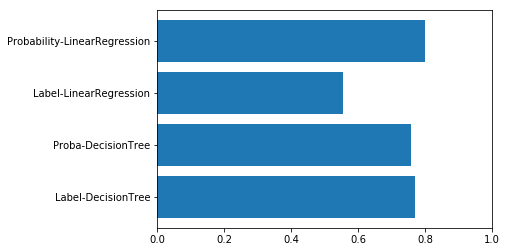

In [168]:
#Plot showing the performances of the superlearners under different stacklayer models and stack layer training
#approaches
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))

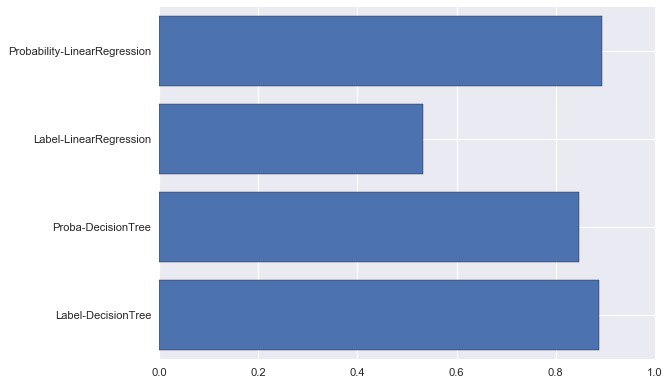

In [235]:
#Plot showing the performances of the superlearners under different stacklayer models and stack layer training
#approaches
#TEST DATA LOADED from MNIST_Test.csv
plt.xlim(0, 1.0)
_ = plt.barh(range(len(mode_test_accuracy_comparisons_TESTCSV)), list(mode_test_accuracy_comparisons_TESTCSV.values()), align='center')
_ = plt.yticks(range(len(mode_test_accuracy_comparisons_TESTCSV)), list(mode_test_accuracy_comparisons_TESTCSV.keys()))

## Grid Search Through SuperLearnerClassifier Architectures & Parameters 

Perfrom a grid search experiment to detemrine the optimal architecture and hyper-parameter values for the SuperLearnClasssifier for the MNIST Fashion classification problem.

In [240]:
# Add code here
#GridSearch on Different StackModels
#Different stack Classifiers
tr=tree.DecisionTreeClassifier(criterion="entropy")
lr = LogisticRegression(C=100, random_state=SEED)
listOfStackModels=[tr,lr]
#Different Base Classifiers
nb = GaussianNB()
svc = SVC(C=100, probability=True)
knn = KNeighborsClassifier(n_neighbors=3)
lr = LogisticRegression(C=100, random_state=SEED)
nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)
from sklearn.tree import DecisionTreeClassifier
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME",n_estimators=50)
baseModelsList=[nb,svc,knn,lr,nn,gb,rf]
baseModelsList1=[nb,knn,lr,gb,rf]
baseModelsList2=[nb,knn,lr,gb,rf,bdt]

BList=[baseModelsList,baseModelsList1,baseModelsList2]
#To use labels or probabilities
predProbaList=[False,True]
#creating the param grid for the gridSearch
#
useOriginalInputList=[False]
param_grid=dict(baseModels=BList,stackModel=listOfStackModels,predProba=predProbaList,useOriginalInput=useOriginalInputList)
grid= GridSearchCV(SuperLearnerClassifier(),param_grid,cv=10,scoring='accuracy')
grid.fit(XTrain,YTrain)
#To view the results
#grid.grid_scores_
#Evaluating to find the best model
#print(grid.best_score_)
#print(grid.best_params_)
#Evaluating to find the best model
print(grid.best_score_)
print(grid.best_params_)

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
0.852
{'baseModels': [GaussianNB(priors=None), SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbor

In [241]:
#To find the best score from grid
grid.best_score_

0.85199999999999998

In [242]:
#to find the best params selected by grid
grid.best_params_

{'baseModels': [GaussianNB(priors=None),
  SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False),
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=3, p=2,
             weights='uniform'),
  LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=222, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
         beta_2=0.999, early_stopping=False, epsilon=1e-08,
         hidden_layer_sizes=(80, 10), learning_rate='constant',
         learning_rate_init=0.001, max_iter=200, momentum=0.9,
         nestero

Evaluate the performance of the model selected by the grid search on a hold-out dataset

In [243]:
#Evaluting the performance of the model selected by the grid search on Train Data
gridPreds=grid.predict(XTrain)
accuracy = metrics.accuracy_score(gridPreds,YTrain)
print("Accuracy:" +str(accuracy))
print(metrics.classification_report(gridPreds, YTrain))

Accuracy:0.999333333333
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       323
          1       1.00      1.00      1.00       318
          2       1.00      1.00      1.00       305
          3       1.00      1.00      1.00       291
          4       1.00      1.00      1.00       283
          5       1.00      1.00      1.00       267
          6       1.00      1.00      1.00       299
          7       1.00      1.00      1.00       314
          8       1.00      1.00      1.00       306
          9       1.00      1.00      1.00       294

avg / total       1.00      1.00      1.00      3000



In [244]:
#Evaluting the performance of the model selected by the grid search on Test Data
gridPreds=grid.predict(XTest)
accuracy = metrics.accuracy_score(gridPreds,YTest)
print("Accuracy:" +str(accuracy))
print(metrics.classification_report(gridPreds, YTest))

Accuracy:0.838333333333
             precision    recall  f1-score   support

          0       0.81      0.73      0.76       204
          1       0.97      0.97      0.97       180
          2       0.77      0.73      0.75       180
          3       0.83      0.84      0.83       173
          4       0.74      0.70      0.72       189
          5       0.93      0.96      0.95       179
          6       0.49      0.60      0.54       145
          7       0.96      0.93      0.95       179
          8       0.93      0.95      0.94       192
          9       0.93      0.94      0.94       179

avg / total       0.84      0.84      0.84      1800



In [39]:
#Evaluting the performance of the model selected by the grid search on Validation Data
gridPreds=grid.predict(XVal)
accuracy = metrics.accuracy_score(gridPreds,YVal)
print("Accuracy:" +str(accuracy))
print(metrics.classification_report(gridPreds, YVal))

Accuracy:0.796666666667
             precision    recall  f1-score   support

          0       0.70      0.68      0.69        63
          1       0.97      0.98      0.98        61
          2       0.69      0.72      0.70        53
          3       0.85      0.86      0.85        64
          4       0.76      0.64      0.70        61
          5       0.91      0.93      0.92        55
          6       0.39      0.46      0.42        59
          7       0.88      0.97      0.92        62
          8       0.93      0.85      0.89        62
          9       0.93      0.87      0.90        60

avg / total       0.80      0.80      0.80       600



In [246]:
#Evaluting the performance of the model selected by the grid search on Test Data loaded from the MNIST_test.csv
gridPreds=grid.predict(XTest_test)
accuracy = metrics.accuracy_score(gridPreds,YTest_test)
print("Accuracy:" +str(accuracy))
print(metrics.classification_report(gridPreds, YTest_test))

Accuracy:0.893333333333
             precision    recall  f1-score   support

          0       1.00      0.86      0.93        22
          1       0.96      1.00      0.98        22
          2       0.86      0.67      0.75         9
          3       0.93      0.87      0.90        15
          4       0.78      0.82      0.80        17
          5       0.93      1.00      0.97        14
          6       0.60      0.86      0.71         7
          7       1.00      0.86      0.92        21
          8       0.82      1.00      0.90         9
          9       0.87      0.93      0.90        14

avg / total       0.90      0.89      0.89       150



In [40]:
grid.best_params_

{'baseModels': [GaussianNB(priors=None),
  SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False),
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=3, p=2,
             weights='uniform'),
  LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=222, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
         beta_2=0.999, early_stopping=False, epsilon=1e-08,
         hidden_layer_sizes=(80, 10), learning_rate='constant',
         learning_rate_init=0.001, max_iter=200, momentum=0.9,
         nestero

## Evaluating the Impact of Adding Original Descriptive Features at the Stack Layer 

Evaluate the impact of adding original descriptive features at the stack layer.

In [248]:
#Evaluating the performance of the model selected by grid with the use of original features at stack layer
stackModel=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=222, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)

nb = GaussianNB(priors=None)
svc = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0, \
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf', \
    max_iter=-1, probability=True, random_state=None, shrinking=True, \
    tol=0.001, verbose=False)
knn =   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', \
             metric_params=None, n_jobs=1, n_neighbors=3, p=2, \
             weights='uniform')
lr = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True, 
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1, \
            penalty='l2', random_state=222, solver='liblinear', tol=0.0001, \
            verbose=0, warm_start=False)
nn = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9, \
         beta_2=0.999, early_stopping=False, epsilon=1e-08, \
         hidden_layer_sizes=(80, 10), learning_rate='constant', \
         learning_rate_init=0.001, max_iter=200, momentum=0.9, \
         nesterovs_momentum=True, power_t=0.5, random_state=222, \
         shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1, \
         verbose=False, warm_start=False)
gb = GradientBoostingClassifier(criterion='friedman_mse', init=None, \
                learning_rate=0.1, loss='deviance', max_depth=3, \
                max_features=None, max_leaf_nodes=None, \
                min_impurity_split=1e-07, min_samples_leaf=1, \
                min_samples_split=2, min_weight_fraction_leaf=0.0, \
                n_estimators=100, presort='auto', random_state=222, \
                subsample=1.0, verbose=0, warm_start=False)
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', \
              max_depth=None, max_features=3, max_leaf_nodes=None, \
              min_impurity_split=1e-07, min_samples_leaf=1, \
              min_samples_split=2, min_weight_fraction_leaf=0.0, \
              n_estimators=10, n_jobs=1, oob_score=False, random_state=222, \
              verbose=0, warm_start=False)
baseModelsList=[nb,svc,knn,lr,nn,gb,rf]

gridSelectedModel= SuperLearnerClassifier(baseModels,stackModel,predProba=True,useOriginalInput=True)
gridSelectedModel.fit(XTrain,YTrain)
#Evaluating the performance on the Test Data for superLEarner trained using Probability
print("Performance of The SuperLearner trained based on probability outputs")
final_pred_test=gridSelectedModel.predict(XTest)
accuracy = metrics.accuracy_score(final_pred_test,YTest)
print("Accuracy:" +str(accuracy))
print(metrics.classification_report(final_pred_test, YTest))


Done
Performance of The SuperLearner trained based on probability outputs
Accuracy:0.737222222222
             precision    recall  f1-score   support

          0       0.75      0.65      0.69       212
          1       0.93      0.96      0.95       176
          2       0.65      0.51      0.57       214
          3       0.70      0.77      0.73       158
          4       0.60      0.56      0.58       189
          5       0.76      0.95      0.84       147
          6       0.38      0.39      0.39       174
          7       0.92      0.88      0.90       181
          8       0.82      0.90      0.86       179
          9       0.86      0.91      0.88       170

avg / total       0.73      0.74      0.73      1800



In [250]:
#Evaluating the performance on the Test Data for selected by grid params for test data loaded from mnist_test.csv
print("Performance of The SuperLearner trained based on grid selected model evaluated on testcsv data")
final_pred_test=gridSelectedModel.predict(XTest_test)
accuracy = metrics.accuracy_score(final_pred_test,YTest_test)
print("Accuracy:" +str(accuracy))
print(metrics.classification_report(final_pred_test, YTest_test))

Performance of The SuperLearner trained based on grid selected model evaluated on testcsv data
Accuracy:0.84
             precision    recall  f1-score   support

          0       0.95      0.82      0.88        22
          1       0.91      0.95      0.93        22
          2       0.86      0.50      0.63        12
          3       0.79      0.79      0.79        14
          4       0.72      0.72      0.72        18
          5       0.87      1.00      0.93        13
          6       0.80      0.80      0.80        10
          7       1.00      0.86      0.92        21
          8       0.45      1.00      0.62         5
          9       0.87      1.00      0.93        13

avg / total       0.86      0.84      0.84       150



In [ ]:
#We find a decrease in the accuracy after we use the original dataset for training the meta learner. This might be due
#the fact that the number of features in training the meta learner increased which doesnt really help in making
#a better prediction

## Explore the Ensemble Model 

Perform an analysis to investigate the strength of the base estimators and the strengths of the correlations between them.

Printing the Correlation Matrix
          0         1         2         3         4         5         6
0  1.000000  0.005265  0.802848  0.781286  0.345360  0.816142  0.815430
1  0.005265  1.000000 -0.000527  0.015875  0.117302 -0.004830 -0.002367
2  0.802848 -0.000527  1.000000  0.816718  0.278797  0.872988  0.858449
3  0.781286  0.015875  0.816718  1.000000  0.253596  0.844387  0.806402
4  0.345360  0.117302  0.278797  0.253596  1.000000  0.258948  0.268896
5  0.816142 -0.004830  0.872988  0.844387  0.258948  1.000000  0.878769
6  0.815430 -0.002367  0.858449  0.806402  0.268896  0.878769  1.000000


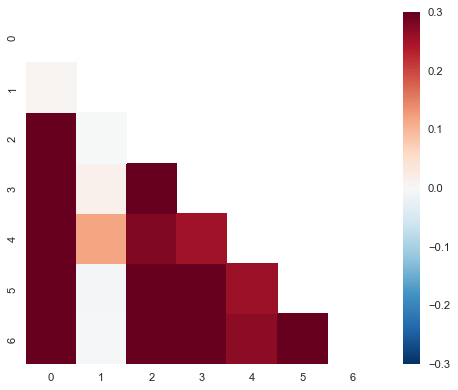

In [220]:
# Calling the function diversity in the superLearner class to find the diversity among the base estimators using
# the correlation(Pearson Corrletion) among the stacked predictions of the base estimators.
superLearner.diversity()

inside
inside
inside
inside
inside
inside
inside


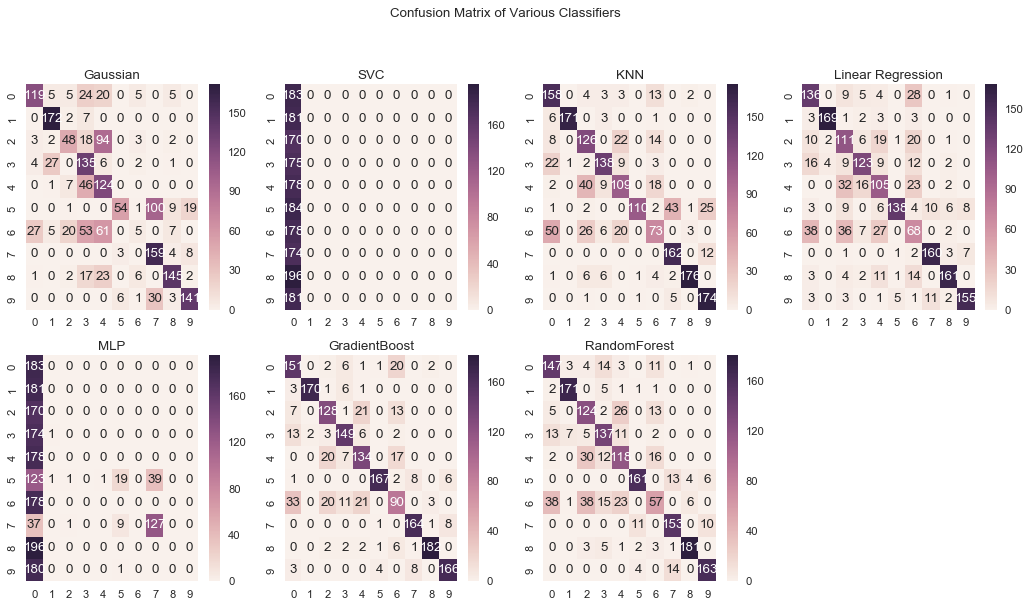

In [221]:
#Calling the confusionHeatMap function of the SuperLearner to display the confusion matrices of the base estimators
#in the superLearner ensemble
superLearner.confusionHeatMap(XTest,YTest)

In [222]:
#calling the predictivePowerEnsemble function of the superLearner class to find the Accuracy ,F1-Measuer,Recall
#Precision measures of all the base estimators in the SuperLearner ensemble
superLearner.predictivePowerEnsemble(XTest,YTest)

Predictive Power of Each of the base model- Model1
Accuracy0.612222222222
F1-Measure0.643656143658
Recall0.612222222222
Precision0.739655566164
Predictive Power of Each of the base model- Model2


/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy0.101666666667
F1-Measure0.184568835098
Recall0.101666666667
Precision1.0
Predictive Power of Each of the base model- Model3
Accuracy0.776111111111
F1-Measure0.780023427172
Recall0.776111111111
Precision0.801704690309
Predictive Power of Each of the base model- Model4
Accuracy0.736666666667
F1-Measure0.732215454444
Recall0.736666666667
Precision0.733249575887
Predictive Power of Each of the base model- Model5
Accuracy0.182777777778
F1-Measure0.254233719535
Recall0.182777777778
Precision0.957864158199
Predictive Power of Each of the base model- Model6
Accuracy0.833888888889
F1-Measure0.834509741475
Recall0.833888888889
Precision0.837316398752
Predictive Power of Each of the base model- Model7
Accuracy0.784444444444
F1-Measure0.790482585556
Recall0.784444444444
Precision0.802416244304


Scatter Plot showing the predictions plot


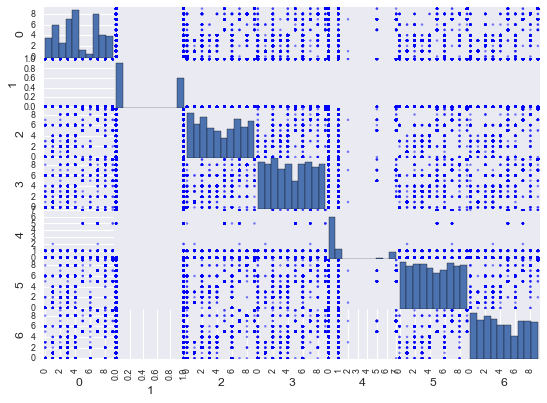

In [223]:
#Calling the scatterPlotforPrediction to display the scatterplot of the stacked predicitons
superLearner.scatterPlotforPrediction()